<a href="https://colab.research.google.com/github/panxiaofan/Advanced-Mahchine-Perception/blob/master/HW2_yolo_part_b_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0

https://drive.google.com/file/d/1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr/view?usp=sharing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='../content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2020')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
  '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
  '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
  '1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz' }      

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Mounted at ../content/drive


# Data Preprocessing

Here you will implement a pytorch data processor that loads tha images and computes the ground truth labels as described in the PDF.


In [2]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def loadData(image_path, labels_path):
  ## use 0.8*no_images as the training data and the remaining as test data.
  images_data = np.load(image_path, allow_pickle=True)
  labels_data = np.load(labels_path, allow_pickle=True, encoding = 'latin1')

  images = images_data['arr_0']
  labels = labels_data['arr_0']

  train_images, test_images, train_raw_labels, test_raw_labels = train_test_split(images, labels, train_size=0.8)
    
  return train_images, train_raw_labels, test_images, test_raw_labels

  # image n*(3,128,128)
  # raw_label(n,5)
  # ground_truth matrix n*8*8*8
  ## this function should compute the 8X8X8 label from the raw labels for the corresponding image.
  # image (3,128,128)
  # raw_label(1,5)
  # ground_truth matrix 8*8*8

def create_y_label(image, label):
  #label:(num_obj,5)
  #image:(128,128,3)
  #return (8*8*8)
  # print(image.shape)
  # print(label.shape)
  num_object=len(label)
  y_label = np.zeros((8,8,8))
  if label.size ==0 or image.size == 0: return y_label
  sign,x1,y1,x2,y2=label[:,0],label[:,1],label[:,2],label[:,3],label[:,4]
  c_x = (x1+x2)/2
  c_y = (y1+y2)/2
  grid_size_x = int(image.shape[0]/8)
  grid_size_y = int(image.shape[1]/8)
  grid_x = (c_x/grid_size_x).astype(int)
  grid_y = (c_y/grid_size_y).astype(int)
  grid_z=np.ones(num_object,dtype=np.int32)

  offset_x=(c_x%grid_size_x)/grid_size_x
  offset_y=(c_y%grid_size_y)/grid_size_y

  w=(x2-x1)/image.shape[0]
  h=(y2-y1)/image.shape[1]

  label_one_hot=np.zeros((num_object,3))
  label_one_hot[np.arange(num_object),(label[:,0]).astype(int)]=1

  #channel 0
  y_label[0*grid_z,grid_x,grid_y]=1
  #channel 1, 2
  y_label[1 * grid_z, grid_x, grid_y] = offset_x
  y_label[2 * grid_z, grid_x, grid_y] = offset_y
  #channel 3, 4
  y_label[3 * grid_z, grid_x, grid_y] = w
  y_label[4 * grid_z, grid_x, grid_y] = h
  #channel 5, 6 ,7
  y_label[5 * grid_z, grid_x, grid_y] = (sign == 0)
  y_label[6 * grid_z, grid_x, grid_y] = (sign == 1)
  y_label[7 * grid_z, grid_x, grid_y] = (sign == 2)
  return y_label
   

TEST your processed y_labels.

The following test checks your create_y_labels function using the test_y_label.npz file.

In [3]:
data = np.load("test_y_labels.npz",allow_pickle=True)
## the test data contains 5 - (image, raw_label, processed_label) that is 5 test cases 

img = data['image']   ## shape (5,3,128,18)
raw_label = data['raw_label']
true_y_label = data['y_label']  ## shape (5,8,8,8)

## fill in your code to compute the your processed y_label
y_label = np.zeros((5,8,8,8))

for i, label in enumerate(raw_label):
  y_label[i] = create_y_label(img[i], label)

# test you processed labels
for i in range(len(img)):
  comparison = y_label[i] == true_y_label[i]
  equal_arrays = comparison.all()
  print('Completed TEST CASE {}: {}'.format(i+1,equal_arrays))


Completed TEST CASE 1: True
Completed TEST CASE 2: True
Completed TEST CASE 3: True
Completed TEST CASE 4: True
Completed TEST CASE 5: True


Test your DATASET

Test your data processing by plotting the images and the processed labels. Compare against the raw labels. 

In [4]:
train_images, train_raw_labels, test_images, test_raw_labels = loadData('images.npz', 'labels.npz')

# Q 7.2.1 image with ground truth bounding box

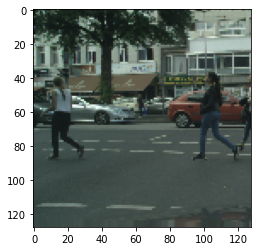

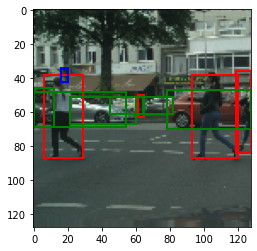

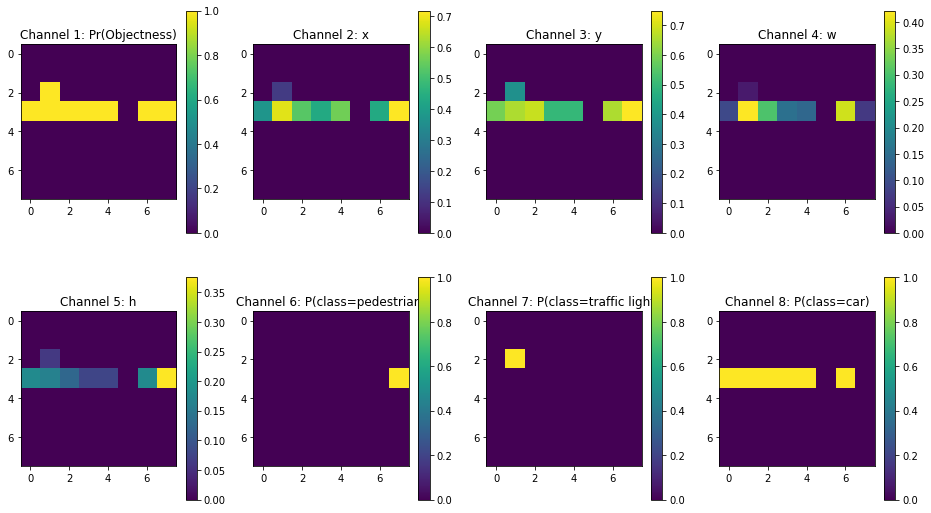

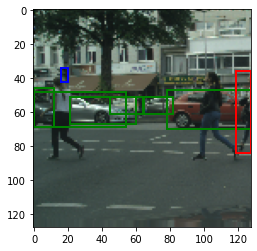

In [6]:
def convert_back_to_raw(grnd_box):
    ## this function should compute raw label from the corresponding 8X8X8 label.
    """
    grnd_box: (8,8,8)
    raw_label: (,n,5)
    """
    if np.count_nonzero(grnd_box[0]) == 0: return np.zeros((0,5))
    raw_label = np.zeros( (np.count_nonzero(grnd_box[0]),5) )
    # raw_label = np.zeros((int(np.sum(grnd_box[0])),5))
    indices = np.where(grnd_box[0])
    center_x, center_y, w, h = grnd_box[1][indices], grnd_box[2][indices], grnd_box[3][indices], grnd_box[4][indices]
    raw_label[:, 1] = (center_x * 16 + indices[0] * 16 - w / 2 * 128).astype(np.int32)
    raw_label[:, 2] = (center_y * 16 + indices[1] * 16 - h / 2 * 128).astype(np.int32)
    raw_label[:, 3] = (center_x * 16 + indices[0] * 16 + w / 2 * 128).astype(np.int32)
    raw_label[:, 4] = (center_y * 16 + indices[1] * 16 + h / 2 * 128).astype(np.int32)
    raw_label[:, 0] = grnd_box[5][indices] * 0 + grnd_box[6][indices] * 1 + grnd_box[7][indices] * 2    
    return raw_label

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
for i in range(len(train_images)):     
  cur_label = train_raw_labels[i][:, 0]
  if np.any(cur_label == 0) and np.any(cur_label == 1) and np.any(cur_label == 2):   
    # 7.2.1
    orig_images = np.squeeze(train_images[i])
    plt.imshow(orig_images)
    plt.savefig(HOMEWORK_FOLDER+'/raw_image.jpg')
    plt.show()
    
    plt.figure()
    plt.imshow(train_images[i])
    ax = plt.gca()
    for j in range(len(train_raw_labels[i])):
        obj = train_raw_labels[i][j]
        x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
        if obj[0] == 0:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 1:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 2:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    plt.savefig(HOMEWORK_FOLDER+'/raw_label.jpg')

    # 7.2.2
    grnd_box = create_y_label(train_images[i],train_raw_labels[i])
    value_list = ['Pr(Objectness)','x', 'y', 'w', 'h', 'P(class=pedestrian)', 'P(class=traffic light)', 'P(class=car)']
    plt.figure(figsize=(16, 9))
    for k in range(len(grnd_box)):
        plt.subplot(2,4,k+1)
        grid_plot = plt.imshow(grnd_box[k].T, interpolation='nearest')
        colorbar = plt.colorbar()
        plt.title('Channel '+ str(k+1) + ': ' + value_list[k])
    plt.savefig(HOMEWORK_FOLDER+'/8x8x8.jpg')
    
    # 7.2.3
    plt.figure()
    plt.imshow(train_images[i])
    ax = plt.gca()
    back_label = convert_back_to_raw(grnd_box)
    for m in range(len(back_label)):
        obj = back_label[m]
        x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
        if obj[0] == 0:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 1:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
        elif obj[0] == 2:
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    plt.savefig(HOMEWORK_FOLDER+'/back_label.jpg')

    break

Set up the data set for training and testing.

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

## use the processed labels and use the correct image dimensions for the pytorch loader.
## images = images.transpose(0,3,1,2)

class YOLODataset(TensorDataset):
    """
    TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        # self.imgs_data = np.load(imgs_path, allow_pickle=True)["arr_0"]
        # self.labels_data = np.load(labels_path, allow_pickle=True,encoding="latin1")["arr_0"]
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]/255

        if self.transform is not None:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y
        # img = torch.tensor(self.imgs_data[index]/255, dtype = torch.float)
        # label = torch.tensor(self.labels_data[index], dtype = torch.float)
        # return img, label

    def __len__(self):
        return self.tensors[0].size(0)

BATCH_SIZE = 64
train_labels = np.zeros((len(train_images), 8, 8, 8))

for i in range(len(train_images)):
    train_labels[i] = create_y_label(train_images[i], train_raw_labels[i])
train_dataset = YOLODataset((torch.Tensor(train_images.transpose(0,3,1,2)) , torch.Tensor(train_labels)), 
                              transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_labels = np.zeros((len(test_images), 8, 8, 8))
for i in range(len(test_images)):
    test_labels[i] = create_y_label(test_images[i], test_raw_labels[i])
test_dataset = YOLODataset((torch.Tensor(test_images.transpose(0,3,1,2)) , torch.Tensor(test_labels)), 
                              transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Model Definition

In [8]:
class YOLO(torch.nn.Module):
    def __init__(self):
        super(YOLO, self).__init__() # 128x128x3
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(4, 4), stride=2, padding=1), # 64x64x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, kernel_size=(4, 4), stride=2, padding=1), # 32x32x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=2, padding=1), # 16x16x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=2, padding=1), # 8x8x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=2, padding=1), # 4x4x512
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 1024, kernel_size=(4, 4), stride=2, padding=1), # 2x2x1024
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=2, padding=1), # 4x4x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=2, padding=1), # 8x8x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 8, kernel_size=(3, 3), stride=1, padding=1), # 8x8x8
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.conv(X)

# Training you network

Start by defining the 
1. IOU
2. appropropriate loss function.
3. NMS - non-max suppression function
4. Average precision function

Please define additional functions as needed.

In [216]:
def IOU(bbox_1 ,bbox_2):
  x_1up,y_1up,x_1l,y_1l=bbox_1[:,0],bbox_1[:,1],bbox_1[:,2],bbox_1[:,3]
  x_2up,y_2up,x_2l,y_2l=bbox_2[:,0],bbox_2[:,1],bbox_2[:,2],bbox_2[:,3]
  
  x_up=torch.max(x_1up,x_2up)
  y_up=torch.max(y_1up,y_2up)

  x_l=torch.min(x_1l,x_2l)
  y_l=torch.min(y_1l,y_2l)

  inter_area = (x_l-x_up).clamp(min=0) * (y_l-y_up).clamp(min=0)

  area_box1 = (x_1l-x_1up).clamp(min=0) * (y_1l-y_1up).clamp(min=0)
  area_box2 = (x_2l-x_2up).clamp(min=0) * (y_2l-y_2up).clamp(min=0)
  union_area=area_box1+area_box2-inter_area
  iou=(inter_area+ 1e-3)/(union_area+1e-3)  

  return iou

def decode_box(code,objects):
  num_object=len(objects)
  x,y,w,h=code[:,1],code[:,2],code[:,3],code[:,4]
  re_w=w*128  #128
  re_h=h*128
  re_x=x*16
  re_y=y*16
  grid_x=objects[:,1]
  grid_y=objects[:,2]
  box=torch.zeros((num_object,4)).to(device)
  box[:,0]=grid_x*16 + re_x-re_w/2
  box[:,1]=grid_y*16 + re_y-re_h/2
  box[:,2]=grid_x*16 + re_x+re_w/2
  box[:,3]=grid_y*16 + re_y+re_h/2  #offset maybe not necessary
  return box

def calc_confidence_score(prediction, grnd_truth,objects):
  ## please fill in additional arguements
  num_objects=prediction.shape[0]
  # C_true=torch.zeros(num_objects).to(device)

## for each object compute the predicted bounding box and grnd_truth bounding box
  predicted_bbox = decode_box(prediction,objects)  
  grnd_truth_bbox = decode_box(grnd_truth,objects)
## next compute the iou of the predicted_bbox and the grnd_truth_bbox
  iou = IOU(predicted_bbox,grnd_truth_bbox)
  return iou


def YoloLoss(output, target, lambda_coord, lambda_noobj, lambda_conf):
  ## please fill in additional arguements
  objects=target[:,0,:,:].nonzero()
  non_objects=(target[:,0,:,:]==0).nonzero()

  target_objects=target[objects[:,0],:,objects[:,1],objects[:,2]]
  predicted_objects=output[objects[:,0],:,objects[:,1],objects[:,2]]
  non_predicted_objects=output[non_objects[:,0],:,non_objects[:,1],non_objects[:,2]]

  locl_c=torch.sum((target_objects[:,1]-predicted_objects[:,1])**2+(target_objects[:,2]-predicted_objects[:,2])**2)
  locl_w=torch.sum((torch.sqrt(target_objects[:,3])-torch.sqrt(predicted_objects[:,3]))**2 + (torch.sqrt(target_objects[:,4])-torch.sqrt(predicted_objects[:,4]))**2)

  conf=calc_confidence_score(predicted_objects,target_objects,objects)
  conf_1=torch.ones(conf.shape).to(device)                                   ##set C_target=1

  loss_conf_object=torch.sum((conf_1-predicted_objects[:,0])**2)
  loss_conf_no_object=torch.sum((non_predicted_objects[:,0])**2)
  
  loss_class=torch.sum((target_objects[:,5]-predicted_objects[:,5])**2+(target_objects[:,6]-predicted_objects[:,6])**2+(target_objects[:,7]-predicted_objects[:,7])**2)
  
  loc_loss=lambda_coord*(locl_c+locl_w)
  conf_loss=lambda_conf*loss_conf_object+lambda_noobj*loss_conf_no_object
  loss=loc_loss+conf_loss+loss_class
  return loss,loss_class,loc_loss,conf_loss


**Train your network **

We suggest that you save checkpoints sand reload from the most recent. This is due time constraints within Colab


In [217]:
import torch.nn as nn
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')
torch.manual_seed(0)

yolo_net=YOLO()
yolo_net=yolo_net.to(device)
learning_rate = 4e-3 

## intialize optimizer
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0006)
num_epochs = 40 ## intialize this, atleast 20 epoch required for training
train_losses = []
train_class_losses = []
train_loc_losses = []
train_conf_losses = []

test_losses = []
test_class_losses = []
test_loc_losses = []
test_conf_losses = []
check_num= 10
entire_mAP=[]

In [218]:
def get_class_name(i):
    switcher={
          0: 'Pedestrians', 
          1: 'Traffic lights', 
          2: 'Cars' 
          }
    return switcher.get(i,"Invalid class")
def average_precision(class_match,class_score,class_trues,pc_threshold,class_name):
    ## it might be helpful to use - from sklearn.metrics import auc to compute area under the curve.
    maximum_score=max(class_score)
    ln=np.linspace(pc_threshold,maximum_score,num=2000)
    precision_mat=np.zeros(2001)
    recall_mat=np.zeros(2001)
    for i, th in enumerate(ln):
      class_score=np.asarray(class_score)
      class_match=np.asarray(class_match)
      matches = (class_score>th).nonzero() ## index where score > th  mathes is tuple of array    
      TP=np.count_nonzero(class_match[matches]==1)    
      total_positive=len(class_match[matches])
      # print(class_name)
      # print("TP " + str(TP)) 
      # print("total_positive " + str(total_positive)+"\n")
      precision=1
      if total_positive>0:
        precision=TP/total_positive
      recall=0
      if class_trues>0:
        recall=TP/class_trues
      precision_mat[i]=precision
      recall_mat[i]=recall
    recall_mat[2000]=0
    precision_mat[2000]=1    
    sorted_index=np.argsort(recall_mat)
    sorted_recall=recall_mat[sorted_index]
    sorted_precision=precision_mat[sorted_index]
    area=metrics.auc(sorted_recall, sorted_precision)
    return area
def NMS(bbox,conf_score):
    ## Non max Suppression 
    num_box = len(bbox)
    iou_mat=torch.zeros((num_box,num_box)).to(device)
    for x in range(num_box):
      for y in range(num_box):
        iou_mat[x,y]=IOU(torch.unsqueeze(bbox[x,:], 0), torch.unsqueeze(bbox[y,:], 0)) 
    max_index=set()
    for i in range(len(iou_mat)):
      group=[]
      for j in range(len(iou_mat)):
        if iou_mat[i,j]> nms_threshold:
          group.append(j)
      if len(group)==1: 
        max_index.add(i) 
        continue
      group_score=conf_score[group]
      max_conf_bbox_group=torch.max(group_score)
      index=(conf_score == max_conf_bbox_group).nonzero()
      index=index.cpu().flatten().numpy().astype(int)
      index_num=len(index)
      if len(index)>1 : index=index[0]
      index=int(index)
      max_index.add(index)
    all_index=list(range(len(iou_mat)))
    all_index = [ elem for elem in all_index if elem not in list(max_index)] 
    if len(all_index)==0:
      return bbox, conf_score   
    conf_score=conf_score[list(max_index)]
    bbox=bbox[list(max_index),:]
    return bbox, conf_score
def yolo_evaluation(data,label,target,idx):
      match_dictionary = {"0": [], "1": [],"2": []}
      score_dictionary = {"0": [], "1": [],"2":[]}
      trues_dictionary = {"0": 0, "1": 0,"2": 0}

      total_match=0
      total_true=0  
      target_each=target[idx].cpu().numpy()  # target_each (8,8,8)
      grnd_label=convert_back_to_raw(target_each)   ##grnd_label:(num_obj,5) numpy  (class_label,x1,y1,x2,y2)
      total_true =grnd_label.shape[0]
      label[0,:,:] = torch.where(label[0,:,:]<=pc_threshold, torch.zeros(label[0,:,:].shape).to(device), label[0,:,:]) 
      object_pos = torch.nonzero(label[0,:,:]).cpu()
         
      if len(object_pos)==0: 
        for class_id in range(0,3):
          class_trues= np.count_nonzero(grnd_label[:,0]==class_id)
          trues_dictionary[str(class_id)]=class_trues
        return match_dictionary,score_dictionary,trues_dictionary
        
      max_prob_matrix = torch.max(torch.max(label[5,:,:],label[6,:,:]),label[7,:,:])
      for class_id in range(0,3):
        class_trues= np.count_nonzero(grnd_label[:,0]==class_id)
        trues_dictionary[str(class_id)]=class_trues
        if class_trues == 0: 
          continue
        grnd_label_class=grnd_label[grnd_label[:,0]==class_id]       ##grnd_label_class:(num_obj,5) numpy         
        
        grnd_box_class=torch.from_numpy(grnd_label_class[:,1:5]).to(torch.float).to(device)  
        num_grnd_box=grnd_label_class.shape[0]      
        class_mask = torch.nonzero(label[5+class_id,:,:]==max_prob_matrix).cpu()
        class_pos = intersection(object_pos,class_mask)

        if len(class_pos)==0:                                               # class_trues>0, class_score and class_match =[]
          continue
        num_box=len(class_pos)
        grid_x, grid_y = class_pos[:,0],class_pos[:,1]
        grid_z = np.ones(num_box,dtype=np.int32)
        conf_score,x,y,w,h=label[0*grid_z,grid_x,grid_y],label[1*grid_z,grid_x,grid_y],label[2*grid_z,grid_x,grid_y],label[3*grid_z,grid_x,grid_y],label[4*grid_z,grid_x,grid_y]
        re_x,re_y=x*16,y*16  
        box=torch.zeros((num_box,4)).to(device)
        box[:,0]=grid_x*16 + re_x-w/2*128
        box[:,1]=grid_y*16 + re_y-h/2*128
        box[:,2]=grid_x*16 + re_x+w/2*128
        box[:,3]=grid_y*16 + re_y+h/2*128  #float tensor
        box=box.detach()
        bbox, conf_score=NMS(box,conf_score)
        class_name=class_id*torch.ones((bbox.shape[0],1)).to(device)
        class_label_after_nms=torch.cat((class_name,bbox),dim=1) 
        class_label_after_nms=class_label_after_nms.cpu().numpy() ##class_label_after_nms:(num_obj,5) numpy

        class_match=np.zeros(bbox.shape[0])
        class_score=conf_score.cpu().detach().numpy()

        iou_mat_pred_grnd=np.zeros((bbox.shape[0],num_grnd_box))
        for i in range(bbox.shape[0]):
          for j in range(num_grnd_box):
            if IOU(torch.unsqueeze(bbox[i,:], 0), torch.unsqueeze(grnd_box_class[j,:], 0))> nms_threshold:
              class_match[i]=1
              break
        match_dictionary[str(class_id)]=class_match.astype(int).tolist()
        score_dictionary[str(class_id)]=class_score.astype(float).tolist()
        
        total_match+=np.count_nonzero(class_match)       
      return match_dictionary,score_dictionary,trues_dictionary

In [219]:
for epoch in range(num_epochs):
    ## fill in your training code
    yolo_net.train()
    running_loss = 0.0
    running_class_loss=0.0
    running_loc_loss=0.0
    running_conf_loss=0.0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = yolo_net(data)
        loss,loss_class,loc_loss,conf_loss = YoloLoss(output, target, lambda_coord=5, lambda_noobj=0.5,lambda_conf = 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_class_loss += loss_class.item()
        running_loc_loss += loc_loss.item()
        running_conf_loss += conf_loss.item()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_class_loss = running_class_loss / len(train_dataloader.dataset)
    epoch_loc_loss = running_loc_loss / len(train_dataloader.dataset)
    epoch_conf_loss = running_conf_loss / len(train_dataloader.dataset)

    train_losses.append(epoch_loss)
    train_class_losses.append(epoch_class_loss)
    train_loc_losses.append(epoch_loc_loss)
    train_conf_losses.append(epoch_conf_loss)
    print('Epoch:{} Avg. train loss: {:.4f}'.format(epoch + 1, epoch_loss))
    if epoch % check_num == 9:
      path = HOMEWORK_FOLDER+'/yolo_epoch_'+str(epoch)
      torch.save({
              'epoch': epoch,
              'model_state_dict': yolo_net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, path)
      yolo_net.eval()
      test_running_loss = 0.0    
      test_running_class_loss=0.0
      test_running_loc_loss=0.0
      test_running_conf_loss=0.0
      total_trues_dictionary = {"0": 0, "1": 0, "2":0}
      match_values_dictionary = {"0": [], "1": [],"2":[]}
      score_values_dictionary = {"0": [], "1": [],"2":[]}

      for batch_idx, (data, target) in enumerate(test_dataloader):   
          data, target = data.to(device), target.to(device)
          output = yolo_net(data) 
          loss,loss_class,loc_loss,conf_loss = YoloLoss(output, target, lambda_coord=5, lambda_noobj=0.5,lambda_conf=1)
          test_running_loss += loss.item()
          test_running_class_loss += loss_class.item()
          test_running_loc_loss += loc_loss.item()
          test_running_conf_loss += conf_loss.item()
          for idx,label in enumerate(output):   #label(8,8,8)  for every image
            match_dictionary,score_dictionary,trues_dictionary=yolo_evaluation(data,label,target,idx)
            for class_id in range(0,3):
              total_trues_dictionary[str(class_id)]+=trues_dictionary[str(class_id)]
              match_values_dictionary[str(class_id)]+=match_dictionary[str(class_id)]
              score_values_dictionary[str(class_id)]+=score_dictionary[str(class_id)]
      epoch_loss = test_running_loss / len(test_dataloader.dataset)
      epoch_class_loss = test_running_class_loss / len(test_dataloader.dataset)
      epoch_loc_loss = test_running_loc_loss / len(test_dataloader.dataset)
      epoch_conf_loss = test_running_conf_loss / len(test_dataloader.dataset)
      test_losses.append(epoch_loss)
      test_class_losses.append(epoch_class_loss)
      test_loc_losses.append(epoch_loc_loss)
      test_conf_losses.append(epoch_conf_loss)
      print('\nEpoch:{} Avg. test loss: {:.4f}\n'.format(epoch + 1, epoch_loss))
      pc_threshold=0.3
      AP=0
      cnt=0
      for class_id in range(0,3):
        if len(match_values_dictionary[str(class_id)])>0:
          class_name=get_class_number(class_id)
          AP+= average_precision(match_values_dictionary[str(class_id)],score_values_dictionary[str(class_id)],total_trues_dictionary[str(class_id)],pc_threshold,get_class_name(class_id))
          cnt+=1
        if cnt>0:
          mAP=AP/cnt
      print('\nEpoch:{} mAP: {:.4f}\n'.format(epoch + 1, mAP))
      entire_mAP.append(mAP)


Epoch:1 Avg. train loss: 7.3658
Epoch:2 Avg. train loss: 6.2628
Epoch:3 Avg. train loss: 5.5846
Epoch:4 Avg. train loss: 5.0262
Epoch:5 Avg. train loss: 4.6352
Epoch:6 Avg. train loss: 4.2383
Epoch:7 Avg. train loss: 3.8709
Epoch:8 Avg. train loss: 3.4517
Epoch:9 Avg. train loss: 3.0398
Epoch:10 Avg. train loss: 2.6154

Epoch:10 Avg. test loss: 3.7890


Epoch:10 mAP: 0.1009

Epoch:11 Avg. train loss: 2.2174
Epoch:12 Avg. train loss: 1.8601
Epoch:13 Avg. train loss: 1.5486
Epoch:14 Avg. train loss: 1.3063
Epoch:15 Avg. train loss: 1.0905
Epoch:16 Avg. train loss: 0.9629
Epoch:17 Avg. train loss: 0.8321
Epoch:18 Avg. train loss: 0.7515
Epoch:19 Avg. train loss: 0.7063
Epoch:20 Avg. train loss: 0.6672

Epoch:20 Avg. test loss: 3.6079


Epoch:20 mAP: 0.1773

Epoch:21 Avg. train loss: 0.6176
Epoch:22 Avg. train loss: 0.5878
Epoch:23 Avg. train loss: 0.5770
Epoch:24 Avg. train loss: 0.5587
Epoch:25 Avg. train loss: 0.5495
Epoch:26 Avg. train loss: 0.5355
Epoch:27 Avg. train loss: 0.5121
Epoc

In [221]:
#save train and test losses to file
import json
with open(HOMEWORK_FOLDER+'/train_loss.txt', 'w') as f:
    f.write(json.dumps(train_losses))
with open(HOMEWORK_FOLDER+'/test_loss.txt', 'w') as f:
    f.write(json.dumps(test_losses))

with open(HOMEWORK_FOLDER+'/train_class_loss.txt', 'w') as f:
    f.write(json.dumps(train_class_losses))
with open(HOMEWORK_FOLDER+'/test_class_loss.txt', 'w') as f:
    f.write(json.dumps(test_class_losses))

with open(HOMEWORK_FOLDER+'/train_loc_loss.txt', 'w') as f:
    f.write(json.dumps(train_loc_losses))
with open(HOMEWORK_FOLDER+'/test_loc_loss.txt', 'w') as f:
    f.write(json.dumps(test_loc_losses))

with open(HOMEWORK_FOLDER+'/train_conf_loss.txt', 'w') as f:
    f.write(json.dumps(train_conf_losses))
with open(HOMEWORK_FOLDER+'/test_conf_loss.txt', 'w') as f:
    f.write(json.dumps(test_conf_losses))

with open(HOMEWORK_FOLDER+'/entire_mAP.txt', 'w') as f:
    f.write(json.dumps(entire_mAP))

In [ ]:
#read train and test losses to file
train_losses = []
train_class_losses = []
train_loc_losses = []
train_conf_losses = []

test_losses = []
test_class_losses = []
test_loc_losses = []
test_conf_losses = []
entire_mAP=[]
with open(HOMEWORK_FOLDER+'/train_loss.txt', 'r') as f:
    train_losses = json.loads(f.read())
with open(HOMEWORK_FOLDER+'/test_loss.txt', 'r') as f:
    test_losses = json.loads(f.read())

with open(HOMEWORK_FOLDER+'/train_class_loss.txt', 'r') as f:
    train_class_losses = json.loads(f.read())
with open(HOMEWORK_FOLDER+'/test_class_loss.txt', 'r') as f:
    test_class_losses = json.loads(f.read())

with open(HOMEWORK_FOLDER+'/train_loc_loss.txt', 'r') as f:
    train_loc_losses = json.loads(f.read())
with open(HOMEWORK_FOLDER+'/test_loc_loss.txt', 'r') as f:
    test_loc_losses = json.loads(f.read())

with open(HOMEWORK_FOLDER+'/train_conf_loss.txt', 'r') as f:
    train_conf_losses = json.loads(f.read())
with open(HOMEWORK_FOLDER+'/test_conf_loss.txt', 'r') as f:
    test_conf_losses = json.loads(f.read())

In [22]:
device = torch.device('cpu')
resume = False # set this True if you want to resume training from a checkpoint
if resume == True:
  path = HOMEWORK_FOLDER+'/yolo_epoch_'+str(29)
  checkpoint = torch.load(path)
  yolo_net=YOLO().to(device)
  yolo_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']

<Figure size 432x288 with 0 Axes>

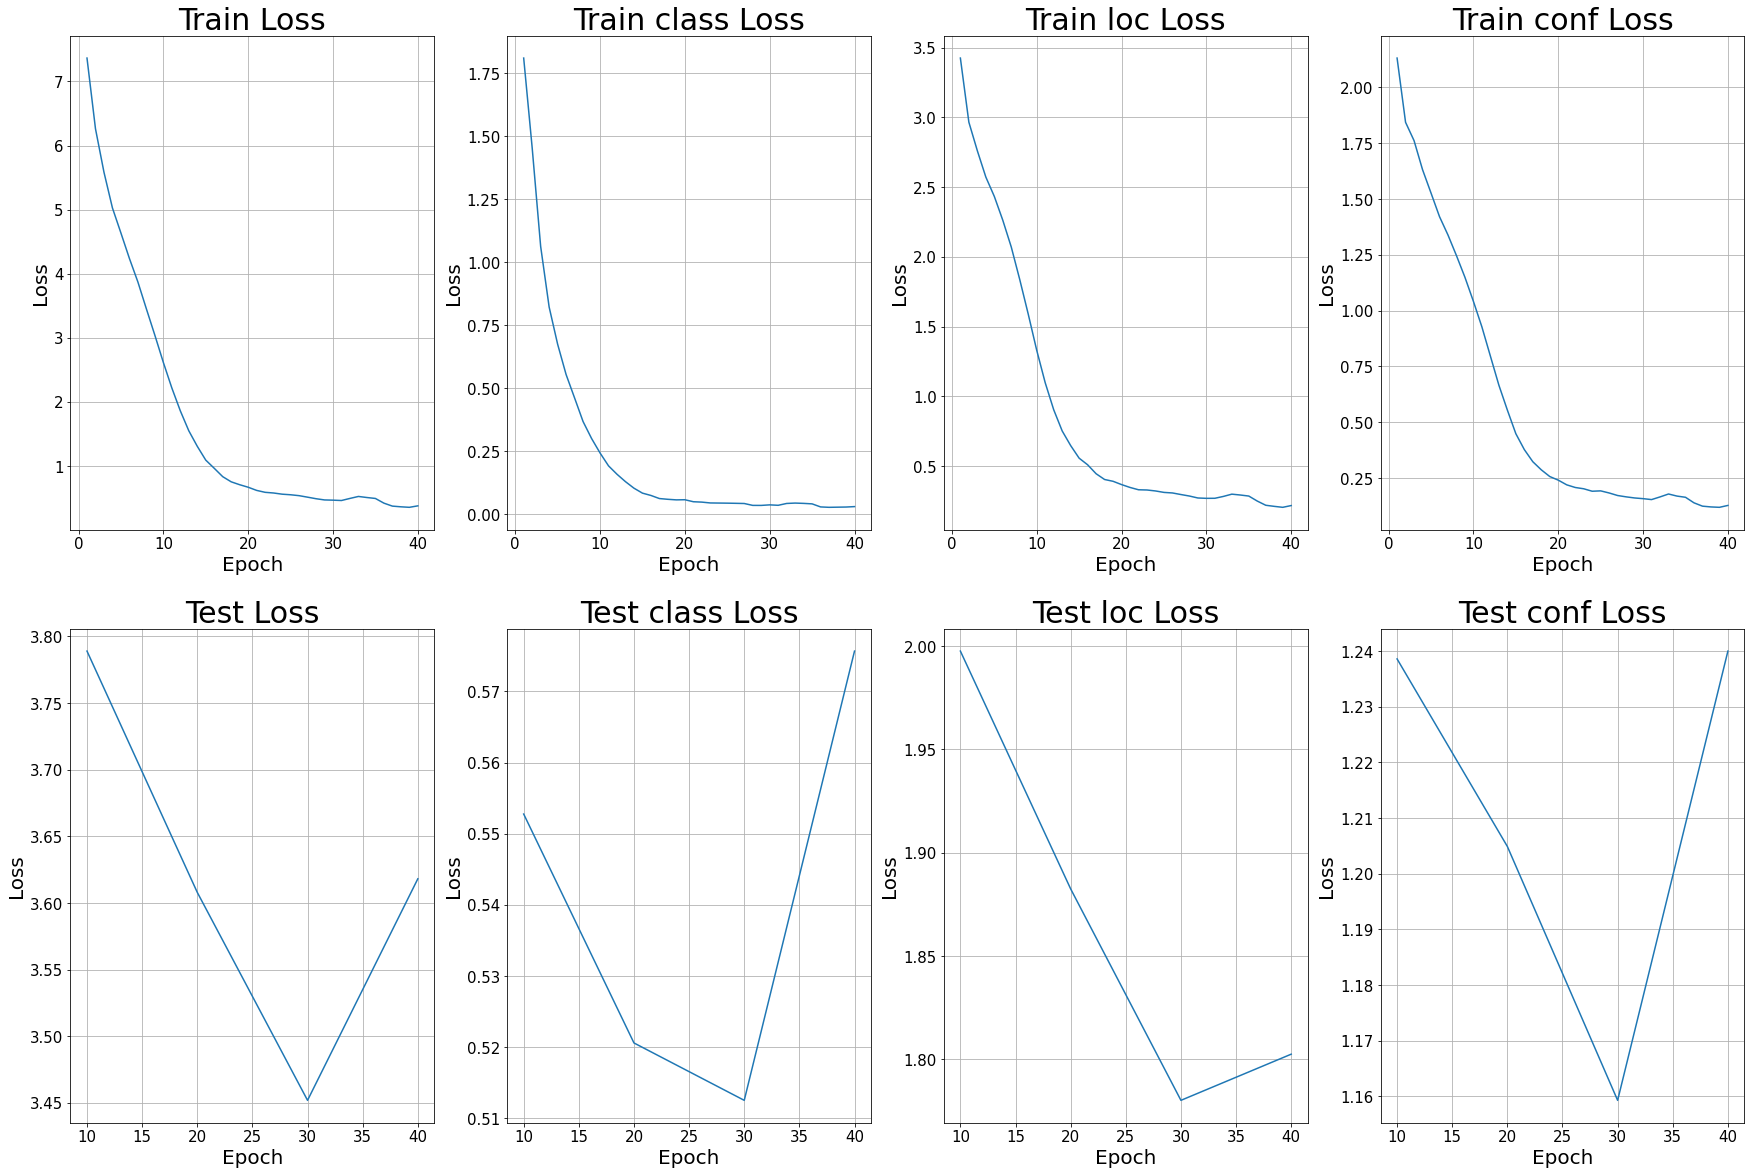

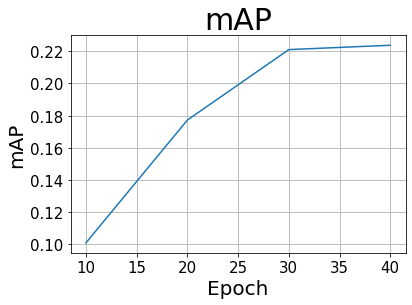

In [230]:
fig = plt.figure()
plt.figure(figsize=(30,20))
plt.subplot(2, 4, 1)
plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses))
plt.tick_params(labelsize=15)
plt.title('Train Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.subplot(2, 4, 2)
plt.plot(np.arange(1, num_epochs + 1), np.array(train_class_losses))
plt.tick_params(labelsize=15)
plt.title('Train class Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.subplot(2, 4, 3)
plt.plot(np.arange(1, num_epochs + 1), np.array(train_loc_losses))
plt.tick_params(labelsize=15)
plt.title('Train loc Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.subplot(2, 4, 4)
plt.plot(np.arange(1, num_epochs + 1), np.array(train_conf_losses))
plt.tick_params(labelsize=15)
plt.title('Train conf Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.subplot(2, 4, 5)
plt.plot(10*np.arange(1, num_epochs/10 + 1), np.array(test_losses))
plt.tick_params(labelsize=15)
plt.title('Test Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.subplot(2, 4, 6)
plt.plot(10*np.arange(1, num_epochs/10 + 1), np.array(test_class_losses))
plt.tick_params(labelsize=15)
plt.title('Test class Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.subplot(2, 4, 7)
plt.plot(10*np.arange(1, num_epochs/10 + 1), np.array(test_loc_losses))
plt.tick_params(labelsize=15)
plt.title('Test loc Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.subplot(2, 4, 8)
plt.plot(10*np.arange(1, num_epochs/10 + 1), np.array(test_conf_losses))
plt.tick_params(labelsize=15)
plt.title('Test conf Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid(b=True)

plt.savefig(HOMEWORK_FOLDER+'/entrie_loss.jpg')
plt.show()

fig = plt.figure()
plt.plot(10*np.arange(1, num_epochs/10 + 1), np.array(entire_mAP))
plt.tick_params(labelsize=15)
plt.title('mAP', fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('mAP', fontsize=20)
plt.grid(b=True)
plt.savefig(HOMEWORK_FOLDER+'/entire_mAP.jpg')
plt.show()

# Test your network.
Use the test images you created in the data preprocessing step. 


In [149]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn import metrics
device = torch.device('cpu')
yolo_net.eval()
nms_threshold = 0.4
pc_threshold=0.3

def intersection(tensor_1, tensor_2): 
  tensor_1=tensor_1.numpy().astype(int).tolist()
  tensor_2=tensor_2.numpy().astype(int).tolist()
  st1 = set(map(tuple, tensor_1))
  st2 = set(map(tuple, tensor_2))
  return  torch.LongTensor(list(set(st1) & set(st2))).to(device)

def IOU(bbox_1 ,bbox_2):
  x_1up,y_1up,x_1l,y_1l=bbox_1[:,0],bbox_1[:,1],bbox_1[:,2],bbox_1[:,3]
  x_2up,y_2up,x_2l,y_2l=bbox_2[:,0],bbox_2[:,1],bbox_2[:,2],bbox_2[:,3]
  x_up=torch.max(x_1up,x_2up)
  y_up=torch.max(y_1up,y_2up)
  x_l=torch.min(x_1l,x_2l)
  y_l=torch.min(y_1l,y_2l)
  inter_area = (x_l-x_up).clamp(min=0) * (y_l-y_up).clamp(min=0)
  area_box1 = (x_1l-x_1up).clamp(min=0) * (y_1l-y_1up).clamp(min=0)
  area_box2 = (x_2l-x_2up).clamp(min=0) * (y_2l-y_2up).clamp(min=0)
  union_area=area_box1+area_box2-inter_area
  iou=(inter_area+ 1e-5)/(union_area+1e-5)  
  return iou

def NMS(bbox,conf_score):
    ## Non max Suppression 
    num_box = len(bbox)
    iou_mat=torch.zeros((num_box,num_box)).to(device)
    for x in range(num_box):
      for y in range(num_box):
        iou_mat[x,y]=IOU(torch.unsqueeze(bbox[x,:], 0), torch.unsqueeze(bbox[y,:], 0)) 
    max_index=set()
    for i in range(len(iou_mat)):
      group=[]
      for j in range(len(iou_mat)):
        if iou_mat[i,j]> nms_threshold:
          group.append(j)
      if len(group)==1: 
        max_index.add(i) 
        continue
      group_score=conf_score[group]
      max_conf_bbox_group=torch.max(group_score)
      index=(conf_score == max_conf_bbox_group).nonzero()
      index=int(index.cpu().flatten().numpy().astype(int))
      max_index.add(index)
    all_index=list(range(len(iou_mat)))
    all_index = [ elem for elem in all_index if elem not in list(max_index)] 
    if len(all_index)==0:
      return bbox, conf_score   
    conf_score=conf_score[list(max_index)]
    bbox=bbox[list(max_index),:]
    return bbox, conf_score

def convert_back_to_raw(grnd_box):
    if np.count_nonzero(grnd_box[0]) == 0: return np.zeros((0,5))
    raw_label = np.zeros( (np.count_nonzero(grnd_box[0]),5) )
    indices = np.where(grnd_box[0])
    center_x, center_y, w, h = grnd_box[1][indices], grnd_box[2][indices], grnd_box[3][indices], grnd_box[4][indices]
    raw_label[:, 1] = (center_x * 16 + indices[0] * 16 - w / 2 * 128).astype(np.int32)
    raw_label[:, 2] = (center_y * 16 + indices[1] * 16 - h / 2 * 128).astype(np.int32)
    raw_label[:, 3] = (center_x * 16 + indices[0] * 16 + w / 2 * 128).astype(np.int32)
    raw_label[:, 4] = (center_y * 16 + indices[1] * 16 + h / 2 * 128).astype(np.int32)
    raw_label[:, 0] = grnd_box[5][indices] * 0 + grnd_box[6][indices] * 1 + grnd_box[7][indices] * 2    
    return raw_label
def get_frame_color(i):
    switcher={
          0: 'r', 
          1: 'b', 
          2: 'g' 
          }
    return switcher.get(i,"Invalid class")


In [225]:
total_trues_dictionary = {"0": 0, "1": 0, "2":0}
match_values_dictionary = {"0": [], "1": [],"2":[]}
score_values_dictionary = {"0": [], "1": [],"2":[]}
for batch_idx, (data, target) in enumerate(test_dataloader):    
    data, target = data.to(device), target.to(device)
    output = yolo_net(data) #label(batch:64,8,8,8) 
    for idx,label in enumerate(output):   #label(8,8,8)  for every image
      match_dictionary,score_dictionary,trues_dictionary=yolo_evaluation(data,label,target,idx)
      for class_id in range(0,3):
        total_trues_dictionary[str(class_id)]+=trues_dictionary[str(class_id)]
        match_values_dictionary[str(class_id)]+=match_dictionary[str(class_id)]
        score_values_dictionary[str(class_id)]+=score_dictionary[str(class_id)]


In [226]:
device = torch.device('cpu')
def get_class_name(i):
    switcher={
          0: 'Pedestrians', 
          1: 'Traffic lights', 
          2: 'Cars' 
          }
    return switcher.get(i,"Invalid class")
def average_precision(class_match,class_score,class_trues,pc_threshold,class_name):
    ## it might be helpful to use - from sklearn.metrics import auc to compute area under the curve.
    maximum_score=max(class_score)
    ln=np.linspace(pc_threshold,maximum_score,num=2000)
    precision_mat=np.zeros(2001)
    recall_mat=np.zeros(2001)
    for i, th in enumerate(ln):
      class_score=np.asarray(class_score)
      class_match=np.asarray(class_match)
      matches = (class_score>th).nonzero() ## index where score > th  mathes is tuple of array    
      TP=np.count_nonzero(class_match[matches]==1)    
      total_positive=len(class_match[matches])
      # print(class_name)
      # print("TP " + str(TP)) 
      # print("total_positive " + str(total_positive)+"\n")
      precision=1
      if total_positive>0:
        precision=TP/total_positive
      recall=0
      if class_trues>0:
        recall=TP/class_trues
      precision_mat[i]=precision
      recall_mat[i]=recall
    recall_mat[2000]=0
    precision_mat[2000]=1    
    sorted_index=np.argsort(recall_mat)
    sorted_recall=recall_mat[sorted_index]
    sorted_precision=precision_mat[sorted_index]
    area=metrics.auc(sorted_recall, sorted_precision)
    
    plt.plot(sorted_recall, sorted_precision)
    return area

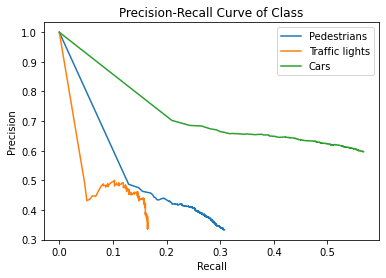

0.2237523328559753

In [229]:
pc_threshold=0.3
AP=0
cnt=0
plt.figure()
plt.xlabel("Recall")
plt.ylabel("Precision") 
plt.title("Precision-Recall Curve of Class")
for class_id in range(0,3):
  if len(match_values_dictionary[str(class_id)])>0:
    class_name=get_class_number(class_id)
    AP+= average_precision(match_values_dictionary[str(class_id)],score_values_dictionary[str(class_id)],total_trues_dictionary[str(class_id)],pc_threshold,get_class_name(class_id))
    cnt+=1
  if cnt>0:
    mAP=AP/cnt
plt.legend(["Pedestrians","Traffic lights","Cars"])
plt.savefig(HOMEWORK_FOLDER+'/Precision-Recall Curve of Class.jpg')
plt.show()
mAP

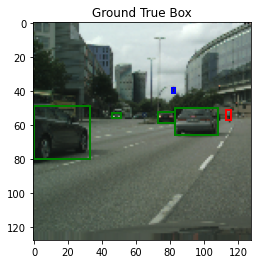

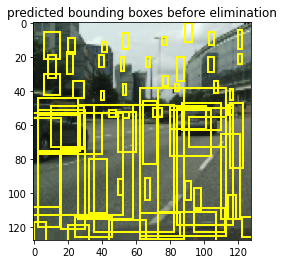

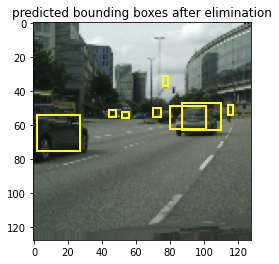

total_match of one_image: 2
total_trues of one_image: 6
match_dictionary
{'0': [0], '1': [0], '2': [0, 1, 0, 0, 1]}
score_dictionary
{'0': [0.9653202891349792], '1': [0.8437944650650024], '2': [0.9999972581863403, 0.9999716281890869, 0.991407573223114, 0.9998520612716675, 0.8993068933486938]}
trues_dictionary
{'0': [1], '1': [1], '2': [4]}


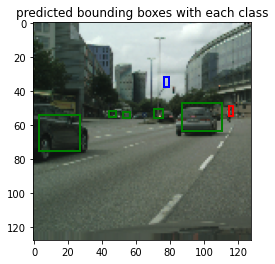

In [172]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn import metrics
yolo_net.eval()
nms_threshold = 0.4
pc_threshold=0.3

def intersection(tensor_1, tensor_2): 
  tensor_1=tensor_1.numpy().astype(int).tolist()
  tensor_2=tensor_2.numpy().astype(int).tolist()
  st1 = set(map(tuple, tensor_1))
  st2 = set(map(tuple, tensor_2))
  return  torch.LongTensor(list(set(st1) & set(st2))).to(device)

def IOU(bbox_1 ,bbox_2):
  # print(bbox_1.shape)
  # print(bbox_2.shape)
  x_1up,y_1up,x_1l,y_1l=bbox_1[:,0],bbox_1[:,1],bbox_1[:,2],bbox_1[:,3]
  x_2up,y_2up,x_2l,y_2l=bbox_2[:,0],bbox_2[:,1],bbox_2[:,2],bbox_2[:,3]
  x_up=torch.max(x_1up,x_2up)
  y_up=torch.max(y_1up,y_2up)
  x_l=torch.min(x_1l,x_2l)
  y_l=torch.min(y_1l,y_2l)
  inter_area = (x_l-x_up).clamp(min=0) * (y_l-y_up).clamp(min=0)
  area_box1 = (x_1l-x_1up).clamp(min=0) * (y_1l-y_1up).clamp(min=0)
  area_box2 = (x_2l-x_2up).clamp(min=0) * (y_2l-y_2up).clamp(min=0)
  union_area=area_box1+area_box2-inter_area
  iou=(inter_area+ 1e-5)/(union_area+1e-5)  
  return iou
 
def convert_back_to_raw(grnd_box):
    if np.count_nonzero(grnd_box[0]) == 0: return np.zeros((0,5))
    raw_label = np.zeros( (np.count_nonzero(grnd_box[0]),5) )
    indices = np.where(grnd_box[0])
    center_x, center_y, w, h = grnd_box[1][indices], grnd_box[2][indices], grnd_box[3][indices], grnd_box[4][indices]
    raw_label[:, 1] = (center_x * 16 + indices[0] * 16 - w / 2 * 128).astype(np.int32)
    raw_label[:, 2] = (center_y * 16 + indices[1] * 16 - h / 2 * 128).astype(np.int32)
    raw_label[:, 3] = (center_x * 16 + indices[0] * 16 + w / 2 * 128).astype(np.int32)
    raw_label[:, 4] = (center_y * 16 + indices[1] * 16 + h / 2 * 128).astype(np.int32)
    raw_label[:, 0] = grnd_box[5][indices] * 0 + grnd_box[6][indices] * 1 + grnd_box[7][indices] * 2    
    return raw_label
def get_frame_color(i):
    switcher={
          0: 'r', 
          1: 'b', 
          2: 'g' 
          }
    return switcher.get(i,"Invalid class")

for batch_idx, (data, target) in enumerate(test_dataloader):
    data, target = data.to(device), target.to(device)
    output = yolo_net(data) #label(batch:64,8,8,8) 
    for idx,label in enumerate(output):   #label(8,8,8)  for every image
      # cur_label = target[idx][:, 0]
      back_label = convert_back_to_raw(target[idx].cpu().numpy())
      if np.any(back_label[:,0] == 0) and np.any(back_label[:,0] == 1) and np.any(back_label[:,0] == 2): 
        total_match=0
        total_true=0  

        ######### 7.6.1 ################
        target_each=target[idx].cpu().numpy()  # target_each (8,8,8)
        grnd_label=convert_back_to_raw(target_each)   ##grnd_label:(num_obj,5) numpy  (class_label,x1,y1,x2,y2)
        plt.figure()
        Image=data[idx].cpu().permute((1,2,0)).numpy()
        plt.imshow(Image)
        ax = plt.gca()
        for m in range(len(grnd_label)):
          obj = grnd_label[m]
          x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
          if obj[0] == 0:
              rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='r', facecolor='none')
              ax.add_patch(rect)
          elif obj[0] == 1:
              rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='b', facecolor='none')
              ax.add_patch(rect)
          elif obj[0] == 2:
              rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='g', facecolor='none')
              ax.add_patch(rect)

        total_true =grnd_label.shape[0]

        plt.title("Ground True Box") 
        plt.savefig(HOMEWORK_FOLDER+'/Ground True Box.jpg')
        plt.show()


        plt.figure()
        Image=data[idx].cpu().permute((1,2,0)).numpy()
        plt.imshow(Image)
        ax = plt.gca()
        raw_pred_box=label.detach().cpu().numpy()    #8,8,8                             #create_y_label:iamge+(num_object,5)->(8*8*8)
        back_label = convert_back_to_raw(raw_pred_box)   #(class_label,x1,y1,x2,y2)       
        for m in range(len(back_label)):    #back_label only calculate (x1,y1,x2,y2) and keep Pc and p for three classes
          obj = back_label[m]
          x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
          rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='yellow', facecolor='none')
          ax.add_patch(rect)
        plt.title("predicted bounding boxes before elimination") 
        plt.savefig(HOMEWORK_FOLDER+'/predicted bounding boxes before elimination.jpg')
        plt.show()
        ##################################################
        label[0,:,:] = torch.where(label[0,:,:]<=pc_threshold, torch.zeros(label[0,:,:].shape).to(device), label[0,:,:]) 
        ############### 7.6.2 ##########
        plt.figure()
        Image=data[idx].cpu().permute((1,2,0)).numpy()
        plt.imshow(Image)
        ax = plt.gca()
        raw_pred_box=label.detach().cpu().numpy()    #8,8,8
        back_label = convert_back_to_raw(raw_pred_box)    
        for m in range(len(back_label)):
          obj = back_label[m]
          x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
          rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor='yellow', facecolor='none')
          ax.add_patch(rect)
        plt.title("predicted bounding boxes after elimination") 
        plt.savefig(HOMEWORK_FOLDER+'/predicted bounding boxes after elimination.jpg')
        plt.show()
        ##################################################
        object_pos = torch.nonzero(label[0,:,:]).cpu()
        if len(object_pos)==0: 
          # print("No object detected!\n") 
          continue
        max_prob_matrix = torch.max(torch.max(label[5,:,:],label[6,:,:]),label[7,:,:])

        plt.figure()
        plt.imshow(Image)
        plt.title("predicted bounding boxes with each class") 
        ax = plt.gca()

        match_dictionary = {"0": [], "1": [],"2":[]}
        score_dictionary = {"0": [], "1": [],"2":[]}
        trues_dictionary = {"0": [], "1": [],"2":[]}

        for class_id in range(0,3):
          class_trues= np.count_nonzero(grnd_label[:,0]==class_id)
          trues_dictionary[str(class_id)].append(class_trues)  # class_trues=0，class_score and class_match =[]
          if class_trues == 0:  
            continue

          grnd_label_class=grnd_label[grnd_label[:,0]==class_id]       ##grnd_label_class:(num_obj,5) numpy         
          
          grnd_box_class=torch.from_numpy(grnd_label_class[:,1:5]).to(torch.float).to(device)  
          num_grnd_box=grnd_label_class.shape[0]     
          class_mask = torch.nonzero(label[5+class_id,:,:]==max_prob_matrix).cpu()
          class_pos = intersection(object_pos,class_mask)

          if len(class_pos)==0:                        # class_trues>0, class_score and class_match =[]
            continue

          num_box=len(class_pos)
          grid_x, grid_y = class_pos[:,0],class_pos[:,1]
          grid_z = np.ones(num_box,dtype=np.int32)
          conf_score,x,y,w,h=label[0*grid_z,grid_x,grid_y],label[1*grid_z,grid_x,grid_y],label[2*grid_z,grid_x,grid_y],label[3*grid_z,grid_x,grid_y],label[4*grid_z,grid_x,grid_y]
          re_x,re_y=x*16,y*16  
          box=torch.zeros((num_box,4)).to(device)
          box[:,0]=grid_x*16 + re_x-w/2*128
          box[:,1]=grid_y*16 + re_y-h/2*128
          box[:,2]=grid_x*16 + re_x+w/2*128
          box[:,3]=grid_y*16 + re_y+h/2*128  #float tensor
          box=box.detach()
          bbox, conf_score=NMS(box,conf_score)
          class_name=class_id*torch.ones((bbox.shape[0],1)).to(device)
          class_label_after_nms=torch.cat((class_name,bbox),dim=1) 
          class_label_after_nms=class_label_after_nms.cpu().numpy() ##class_label_after_nms:(num_obj,5) numpy

          class_match=np.zeros(bbox.shape[0])
          class_score=conf_score.cpu().detach().numpy()

          iou_mat_pred_grnd=np.zeros((bbox.shape[0],num_grnd_box))
          for i in range(bbox.shape[0]):
            for j in range(num_grnd_box):
              if IOU(torch.unsqueeze(bbox[i,:], 0), torch.unsqueeze(grnd_box_class[j,:], 0))> nms_threshold:
                class_match[i]=1
                break
          match_dictionary[str(class_id)]=class_match.astype(int).tolist()
          score_dictionary[str(class_id)]=class_score.astype(float).tolist()
          
          total_match+=np.count_nonzero(class_match)
          ############### 7.7.1 ##########
          Image=data[idx].cpu().permute((1,2,0)).numpy()
          color=get_frame_color(class_id)
          for m in range(len(class_label_after_nms)):
            obj = class_label_after_nms[m]
            x1, y1, x2, y2 = obj[1], obj[2], obj[3], obj[4]
            rect = Rectangle((x1,y1), width=x2-x1, height=y2-y1, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
        ##################################################
        print("total_match of one_image: " + str(total_match))
        print("total_trues of one_image: " + str(total_true))
        print("match_dictionary")
        print(match_dictionary)
        print("score_dictionary")
        print(score_dictionary)
        print("trues_dictionary")
        print(trues_dictionary)

        plt.savefig(HOMEWORK_FOLDER+'/predicted bounding boxes with each class.jpg')
        plt.show()
        break      
    break    
    